# Direct Ptychography Tutorial 01

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/ophusgroup/apmc2025-4dstem-workshop/blob/main/notebooks/try-it-yourself/04.direct_ptychography_01.ipynb)

This is the first tutorial notebook in the direct ptychography series.  
In this tutorial notebook we will cover:
- Complex probe overlap functions
- Single side band (SSB) reconstructions

### Downloads
This tutorial uses the following datasets:
- [dpc_STO_simulation.h5](https://drive.google.com/file/d/1Ml1Ga4-U0ZcTJxq0LVyTJDIVfnBuyd81/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (cophus@stanford.edu)

Last updated: 2025 Feb 01

## Introduction

Direct ptychography techniques are a class of phase retrieval methods which attempts to reconstruct the scattering potential of an electron-transparent sample by deconvolving the effect of the incident illumination (probe aperture and aberrations).

In [1]:
%pip install py4DSTEM > /dev/null 2>&1

In [2]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)
%matplotlib inline

cupyx.jit.rawkernel is experimental. The interface can change in the future.


0.14.18


In [3]:
# Get the 4DSTEM data
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1Ml1Ga4-U0ZcTJxq0LVyTJDIVfnBuyd81',
    destination = '/content/',
    filename = 'dpc_STO_simulation.h5',
    overwrite=True
)

Downloading...
From: https://drive.google.com/uc?id=1Ml1Ga4-U0ZcTJxq0LVyTJDIVfnBuyd81
To: /content/dpc_STO_simulation.h5
100%|██████████| 75.5M/75.5M [00:00<00:00, 114MB/s]


In [4]:
file_path = '/content/'

file_data = file_path + 'dpc_STO_simulation.h5'

dataset = py4DSTEM.read(file_data)
dataset

DataCube( A 4-dimensional array of shape (32, 32, 96, 96) called 'datacube',
          with dimensions:

              Rx = [0.0,0.12328531250000001,0.24657062500000002,...] A
              Ry = [0.0,0.12328531250000001,0.24657062500000002,...] A
              Qx = [0.0,1.0595062826244177,2.1190125652488354,...] mrad
              Qy = [0.0,1.0595062826244177,2.1190125652488354,...] mrad
)

## Inspecting the datacube

First, let's inspect the dataset, $M_{R_x,R_y}(K_x,K_y)$, with $(R_x,R_y)$ real-space dimensions and $(Q_x,Q_y)$ dimensions.

By selecting a pair of $(R_x,R_y)$ positions, we can visualize an example noisy diffraction pattern, and by summing of $(R_x,R_y)$  we can boost the signal-to-noise ratio and get an image of the bright-field disk:

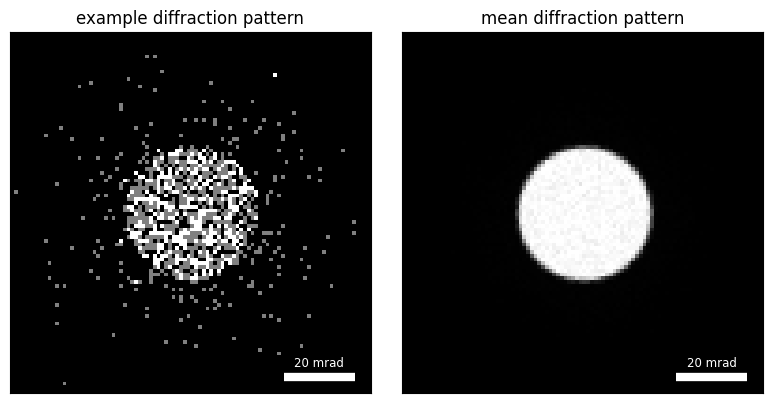

In [5]:
py4DSTEM.show(
    [
        dataset[0,0],
        dataset.data.mean((0,1))
    ],
    ticks=False,
    scalebar=True,
    pixelsize=dataset.calibration.Q_pixel_size,
    pixelunits=dataset.calibration.Q_pixel_units,
    axsize=(4,4),
    title=["example diffraction pattern","mean diffraction pattern"]
)

We can also take the Fourier-transform along the real-space dimensions, to obtain another datacube $G_{Q_x,Q_y}(K_x,K_y)$, where $(Q_x,Q_y)$ are the real-space scan frequencies. Not the dataset will now be complex-valued, so we plot them using `show_complex`:

In [6]:
dataset_real_space_FFT = np.fft.fft2(np.fft.ifftshift(dataset.data,axes=(-1,-2)),axes=(0,1))

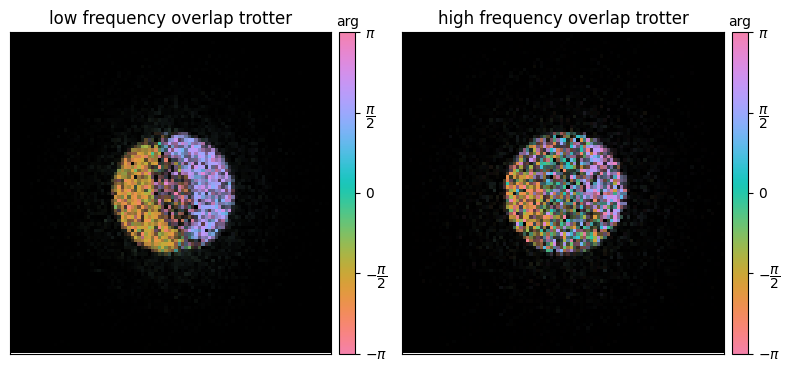

In [7]:
py4DSTEM.show_complex(
    [
        np.fft.fftshift(dataset_real_space_FFT[0,2]),
        np.fft.fftshift(dataset_real_space_FFT[0,4])
    ],
    ticks=False,
    axsize=(4,4),
    title=["low frequency overlap trotter","high frequency overlap trotter"]
)

Visualized in this way, the dataset holds a wealth of information:
- The amplitude $|G_{Q_x,Q_y}(K_x,K_y)|$ of the arrays above for each spatial frequency $(Q_x,Q_y)$ arises from the overlap between the bright-field aperture $A(K_x,K_y)$ and two apertures centered at $A(K_x \pm Q_x,K_y \pm Q_y)$.
  - At high spatial frequencies (right panel), this forms two regions of "double-overlap": $A(K_x,K_y) \land A(K_x+Q_x,K_y+Q_y)$ and $A(K_x,K_y) \land A(K_x-Q_x,K_y-Q_y)$
  - At low spatial frequencies (left panel), the "double-overlap" regions can themselves overlap, leading to the "triple-overlap" region $A(K_x,K_y) \land A(K_x+Q_x,K_y+Q_y) \land A(K_x-Q_x,K_y-Q_y)$
    - At zero-defocus (as above), the "triple-overlap" region cancels out and thus holds no information
    - The similarity of the low-spatial frequency probe overlap regions, gave rise to the colloquialism we'll also adopt, calling them [trotters](https://en.wikipedia.org/wiki/Pig%27s_trotter)
- More importantly, note that the phase of each "trotter" is constant (for zero-defocus) and π-shifted from the other
  - It's precisely this information we'll use to extract the sample phase by deconvolving the effects of the probe aperture (and aberrations)
- The relative rotation of the dataset (here -15°), can also be visualized as the offset of the perpendicular axis between the two trotters

## Modeling probe convolution

If we know our probe aperture (convergence semi-angle) and our probe aberrations well, we can model the effect on the probe in the absence of a sample.

First, let's model our bright-field probe aperture:

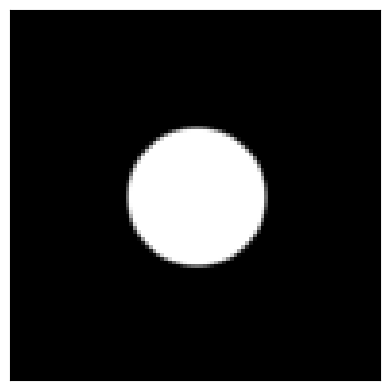

In [8]:
from py4DSTEM.process.phase.utils import ComplexProbe

energy = 200e3 # V
wavelength = py4DSTEM.process.utils.electron_wavelength_angstrom(energy)
semiangle_cutoff = 20 # mrad
gpts = dataset.Qshape

alpha_max = dataset.Q_pixel_size * gpts[0] / 2
k_max = alpha_max * 1e-3 / wavelength
sampling = (1 / k_max / 2, 1 / k_max / 2)

Kx, Ky = tuple(np.fft.fftfreq(n,s) for n,s in zip(gpts,sampling))

bright_field_probe = ComplexProbe(
    energy=energy,
    gpts=gpts,
    sampling=sampling,
    semiangle_cutoff=semiangle_cutoff,
    force_spatial_frequencies=(Kx,Ky)
)
bright_field_alpha, bright_field_phi = bright_field_probe.get_scattering_angles()
bright_field_aperture = bright_field_probe.evaluate_aperture(bright_field_alpha,bright_field_phi)

py4DSTEM.show(
    np.fft.fftshift(bright_field_aperture),
    ticks=False,
    figsize=(4,4),
)

We know (see `dpc_01.ipynb` tutorial for how to obtain this from the dataset directly) that our dataset is rotated by 15°.  
Equivalently, we can rotate the probe-positions $(R_x,R_y)$ (and thus the grid in which we evaluate our spatial frequencies $(Q_x,Q_y)$)

In [9]:
scan_gpts = dataset.Rshape
scan_sampling = (dataset.calibration.R_pixel_size,)*2
rotation_angle = np.deg2rad(-15)
ct = np.cos(-rotation_angle)
st = np.sin(-rotation_angle)

Qx, Qy = tuple(np.fft.fftfreq(n,s) for n,s in zip(scan_gpts,scan_sampling))
Qx, Qy = np.meshgrid(Qx,Qy, indexing='ij')
Qx, Qy = Qx * ct - Qy * st, Qy * ct + Qx * st # rotate

If we now pick one low-spatial frequency, we can form the two shifted apertures like above:

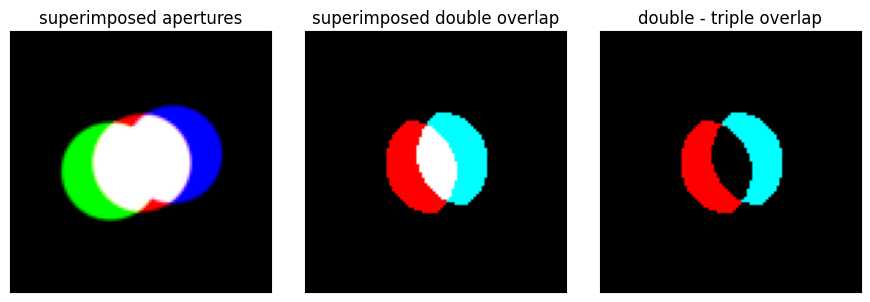

In [10]:
shifted_plus_probe = ComplexProbe(
    energy=energy,
    gpts=gpts,
    sampling=sampling,
    semiangle_cutoff=semiangle_cutoff,
    force_spatial_frequencies=(Kx+Qx[0,2],Ky+Qy[0,2])
)
shifted_plus_alpha, shifted_plus_phi = shifted_plus_probe.get_scattering_angles()
shifted_plus_aperture = shifted_plus_probe.evaluate_aperture(shifted_plus_alpha,shifted_plus_phi)

shifted_minus_probe = ComplexProbe(
    energy=energy,
    gpts=gpts,
    sampling=sampling,
    semiangle_cutoff=semiangle_cutoff,
    force_spatial_frequencies=(Kx-Qx[0,2],Ky-Qy[0,2])
)
shifted_minus_alpha, shifted_minus_phi = shifted_minus_probe.get_scattering_angles()
shifted_minus_aperture = shifted_minus_probe.evaluate_aperture(shifted_minus_alpha,shifted_minus_phi)

double_overlap_plus = np.logical_and(bright_field_aperture,shifted_plus_aperture)
double_overlap_minus = np.logical_and(bright_field_aperture,shifted_minus_aperture)
double_minus_triple_overlap_plus = np.logical_and(double_overlap_plus,1-double_overlap_minus)
double_minus_triple_overlap_minus = np.logical_and(double_overlap_minus,1-double_overlap_plus)

fig, axs = plt.subplots(1,3,figsize=(9,3))

py4DSTEM.show(
    [
        np.fft.fftshift(bright_field_aperture),
        np.fft.fftshift(shifted_plus_aperture),
        np.fft.fftshift(shifted_minus_aperture),
    ],
    ticks=False,
    figax=(fig,axs[0]),
    combine_images=True,
    title="superimposed apertures"
)

py4DSTEM.show(
    [
        np.fft.fftshift(double_overlap_plus),
        np.fft.fftshift(double_overlap_minus),
    ],
    ticks=False,
    figax=(fig,axs[1]),
    combine_images=True,
    title="superimposed double overlap"
)

py4DSTEM.show(
    [
        np.fft.fftshift(double_minus_triple_overlap_plus),
        np.fft.fftshift(double_minus_triple_overlap_minus),
    ],
    ticks=False,
    figax=(fig,axs[2]),
    combine_images=True,
    title="double - triple overlap"
)

fig.tight_layout()

## Deconvolving probe from dataset

We can use on of these double-triple overlap masks, hence the name single side band (SSB), to sum the phase of each trotter to obtain a single complex-value for each spatial frequency $(Q_x,Q_y)$.  
Inverse Fourier transforming that gives us our reconstructed object

In [11]:
reconstructed_object_fft = np.zeros(dataset.Rshape,dtype=np.complex64)

for sx, sy in py4DSTEM.tqdmnd(dataset.R_Nx,dataset.R_Ny):

    shifted_plus_probe = ComplexProbe(
        energy=energy,
        gpts=gpts,
        sampling=sampling,
        semiangle_cutoff=semiangle_cutoff,
        force_spatial_frequencies=(Kx+Qx[sx,sy],Ky+Qy[sx,sy])
    )
    shifted_plus_alpha, shifted_plus_phi = shifted_plus_probe.get_scattering_angles()
    shifted_plus_aperture = shifted_plus_probe.evaluate_aperture(shifted_plus_alpha,shifted_plus_phi)

    shifted_minus_probe = ComplexProbe(
        energy=energy,
        gpts=gpts,
        sampling=sampling,
        semiangle_cutoff=semiangle_cutoff,
        force_spatial_frequencies=(Kx-Qx[sx,sy],Ky-Qy[sx,sy])
    )
    shifted_minus_alpha, shifted_minus_phi = shifted_minus_probe.get_scattering_angles()
    shifted_minus_aperture = shifted_minus_probe.evaluate_aperture(shifted_minus_alpha,shifted_minus_phi)

    double_overlap_plus = np.logical_and(bright_field_aperture,shifted_plus_aperture)
    double_overlap_minus = np.logical_and(bright_field_aperture,shifted_minus_aperture)
    double_minus_triple_overlap_minus = np.logical_and(double_overlap_minus,1-double_overlap_plus)

    G = dataset_real_space_FFT[sx,sy]
    reconstructed_object_fft[sx,sy] = G[double_minus_triple_overlap_minus].sum() * 2

# set scale
reconstructed_object_fft[0,0] = np.abs(dataset_real_space_FFT[0,0]).sum()
mean_intensity = dataset.data.sum((-1,-2)).mean()
reconstructed_object = np.fft.ifft2(reconstructed_object_fft) / mean_intensity

100%|██████████| 1024/1024 [00:00<00:00, 1187.67it/s]


Let's plot our reconstructed object -- note we recover both the amplitude and phase of the object:

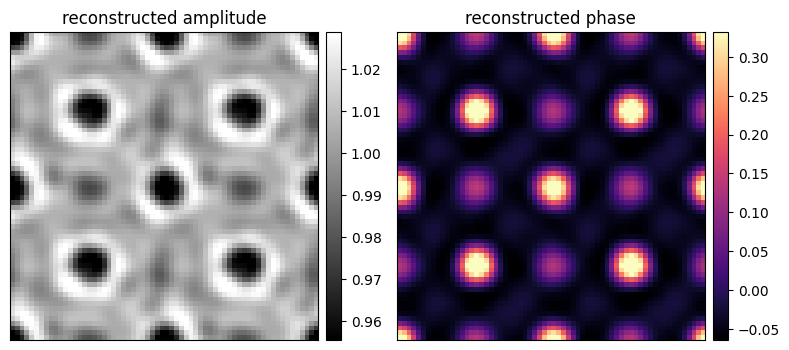

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

for ax, arr, cmap, title in zip(
    axs,
    (np.abs(reconstructed_object),np.angle(reconstructed_object)),
    ('gray','magma'),
    ('reconstructed amplitude','reconstructed phase')
):
    py4DSTEM.show(
        np.tile(arr,(2,2)),
        figax=(fig,ax),
        cmap=cmap,
        ticks=False,
        show_cbar=True,
        title=title,
    )

fig.tight_layout()

## py4DSTEM implementation

Now that we understand what direct ptychography does, let's look at the `py4DSTEM.process.phase.SSB` implementation:

Calculating center of mass: 100%|██████████| 1024/1024 [00:00<00:00, 34287.60probe position/s]
Best fit rotation forced to -15 degrees.
Normalizing amplitudes: 100%|██████████| 1024/1024 [00:01<00:00, 851.39probe position/s]


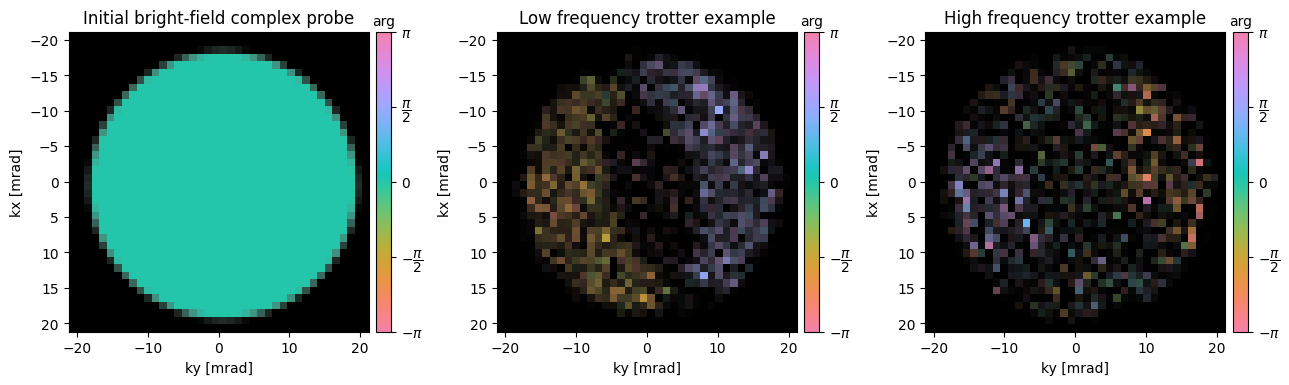

In [13]:
ssb = py4DSTEM.process.phase.SSB(
    energy=energy,
    datacube=dataset,
    semiangle_cutoff=semiangle_cutoff,
    verbose=True,
).preprocess(
    plot_center_of_mass=False,
    plot_rotation=False,
    force_com_rotation=-15,
    vectorized_com_calculation=False,
    crop_around_bf_disk=True,
    bf_disk_padding_px = 2,
)

First, notice that since all the information in the double minus triple overlap region is (by construction) contained inside the BF-disk, we can crop our dataset, to reduce computation time.

As above, we can use one of the trotters to reconsruct the dataset by setting `phase_compensation=False` during reconstruction.

100%|██████████| 1024/1024 [00:00<00:00, 1671.13it/s]


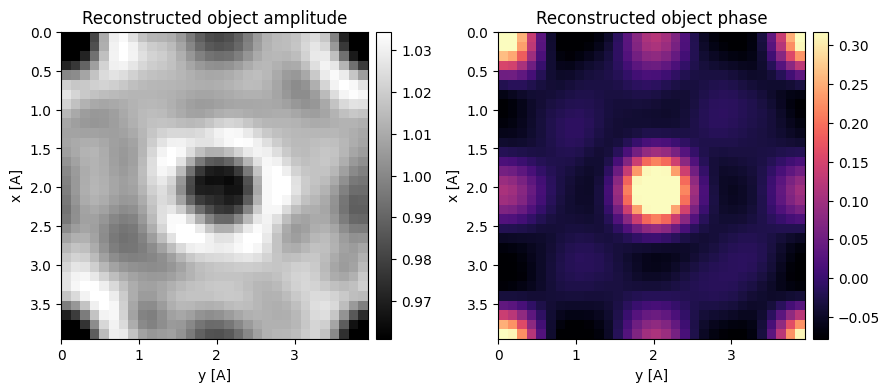

In [14]:
ssb = ssb.reconstruct(
    phase_compensation=False,
    progress_bar=True,
).visualize(
)

reconstructed_object_ssb = ssb.object.copy()

We can in-fact use both the trotters, by properly compensating their relative phase by setting `phase_compensation=True` (the default).   
This uses the formalism described in [[Yang, H. et al. (2016), Ultramic, 171, 117-125]](https://doi.org/10.1016/j.ultramic.2016.09.002) and will further be useful in the case of aberrated probe datasets, see the `direct_ptychography_02.ipynb` tutorial.

100%|██████████| 1024/1024 [00:00<00:00, 1262.54it/s]


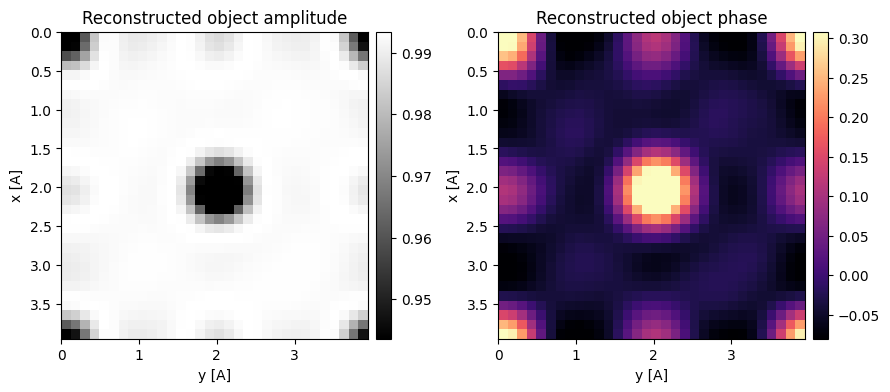

In [15]:
ssb = ssb.reconstruct(
    phase_compensation=True,
    progress_bar=True,
).visualize(
)

reconstructed_object_compensated_ssb = ssb.object.copy()

Notice that the phase of the two reconstructions are quite comparable, but the latter more accuralely regularized the amplitude term.

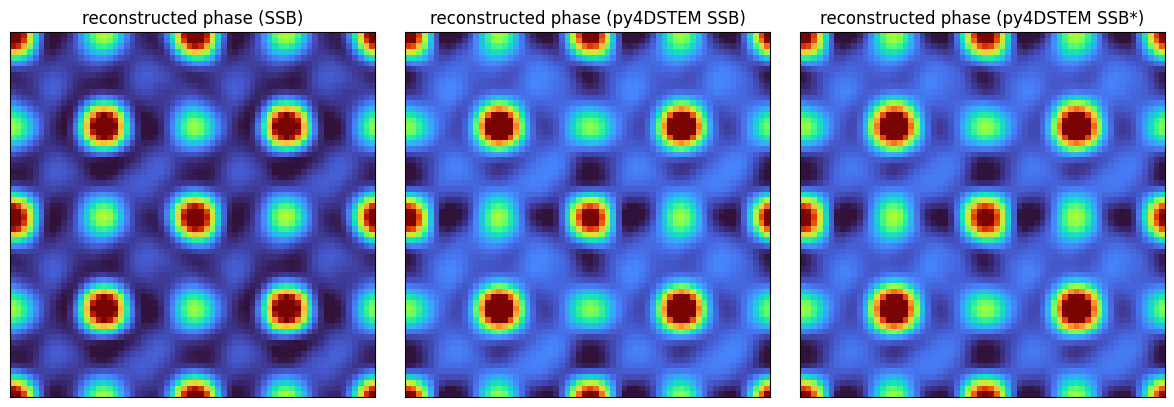

In [16]:
fig, axs = plt.subplots(1,3,figsize=(12,4))

for ax, arr, title in zip(
    axs,
    (np.angle(reconstructed_object),np.angle(reconstructed_object_ssb),np.angle(reconstructed_object_compensated_ssb)),
    ('reconstructed phase (SSB)','reconstructed phase (py4DSTEM SSB)','reconstructed phase (py4DSTEM SSB*)')
):
    py4DSTEM.show(
        np.tile(arr,(2,2)),
        figax=(fig,ax),
        cmap='turbo',
        ticks=False,
        title=title,
    )

fig.tight_layout()